In [113]:
import pandas as pd
import sympy as sy
import matplotlib.pyplot as plt
import numpy as np
import incerts as inc
from scipy.optimize import curve_fit

In [114]:
#   Defining symbols
x, y = sy.symbols('x y')

In [115]:
#   Defining global constants
E  = 8.85
r = 8.56e-3 / 2
sr = 0.01e-3
A = np.pi * r**2
sA = np.pi * inc.incerts(x**2, [x], [r], [sr])
d = 1.86e-3
sd = 0.01e-3

C0 = E * A / d
sC0 =  E * inc.incerts(x/y, [x, y], [A, d], [sA, sd])

errorC = 0.001

plt.figure(figsize=(10, 10), dpi=80)


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [116]:
#   Load data
data = pd.read_csv('FES_Curie.csv')


data['T'] = data['T'].astype(float) + 273.15
data['SUBIDA'] = data['SUBIDA'].astype(float)
data['BAJADA'] = data['BAJADA'].astype(float)


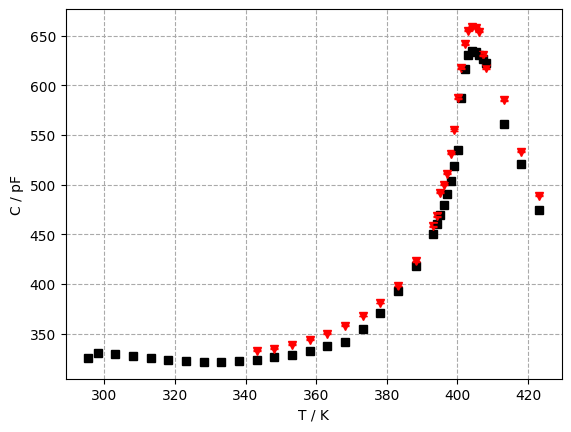

In [117]:
#   Plot C - T

ax = plt.gca()

#   Define uncertanty series

sC_S = errorC * data['SUBIDA'].astype(float)
sC_B = errorC * data['BAJADA'].astype(float)

#sub = data.plot(x = 'T', y = 'SUBIDA', ax = ax, style = 'ks')
#baj = data.plot(x = 'T', y = 'BAJADA', ax = ax, style = 'rv')
plt.errorbar(x = data['T'], y = data['SUBIDA'], yerr = sC_S, barsabove=True, capsize = 3, fmt = 'ks')
plt.errorbar(x = data['T'], y = data['BAJADA'], yerr = sC_B, barsabove=True, capsize = 3, fmt = 'rv')
ax.set_xlabel('T / K')
ax.set_ylabel('C / pF')
ax.grid(linestyle = '--', color = '#aaaaaa')
plt.savefig('C-T.pdf')

In [118]:
#   Define C-W function for fit
def cw(T, C, Tc):
    return 1 + C / (T - Tc)
def rect(T, a, b):
    return a * T + b
def logauss(T, a, b, c):
    return a * np.exp(-(np.log(T)-b)**2/(2*c**2))
def pois (T, a, l):
    return a * l**T * np.exp(-l) / sy.factorial(T)

404.15
404.15


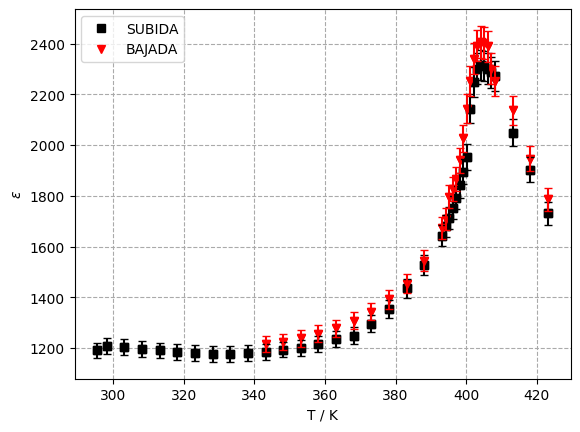

In [119]:
#   Plot \epsilon - T and fitting through C-W
data = pd.read_csv('FES_Curie.csv')
ax = plt.gca()
data = data.reset_index()

data['T'] = data['T'].astype(float) + 273.15
data['SUBIDA'] = data['SUBIDA'].astype(float) / C0
data['BAJADA'] = data['BAJADA'].astype(float) / C0

start = data['BAJADA'].first_valid_index()

sE_S = []
for i in range (len (data['SUBIDA'])):
    sE_S.append(inc.incerts(x / y, [x, y], [data['SUBIDA'].loc[i], C0], [sC_S.loc[i], sC0]))

sE_B = []
for i in range (len (data['BAJADA'].loc[start:])):
    sE_B.append(inc.incerts(x / y, [x, y], [data['BAJADA'].loc[i + start], C0], [sC_B.loc[i + start], sC0]))

max_index_S = np.argmax(data['SUBIDA'])
max_index_B = np.argmax(data['BAJADA'])

sub = data.plot(x = 'T', y = 'SUBIDA', ax = ax, style = 'ks')
baj = data.plot(x = 'T', y = 'BAJADA', ax = ax, style = 'rv')
plt.errorbar(x = data['T'], y = data['SUBIDA'], yerr = sE_S, barsabove=True, capsize = 3, fmt = 'ks')
plt.errorbar(x = data['T'].loc[start:], y = data['BAJADA'].loc[start:], yerr = sE_B, barsabove=True, capsize = 3, fmt = 'rv')


print (data['T'].loc[max_index_B])
print (data['T'].loc[max_index_S])

ax.set_xlabel('T / K')
ax.set_ylabel('$\epsilon$')

ax.grid(linestyle = '--', color = '#aaaaaa')

plt.savefig('e-T.pdf')
#fit_S, cov_S = curve_fit (logauss, data['T'].loc[data.index[data['T'] == 395.15][0]:], data['SUBIDA'].loc[data.index[data['T'] == 395.15][0]:], p0 = [2e3, 400, 10])
#
#x_fit = np.linspace (395, 420, 500)
#y_fit = logauss (x_fit, fit_S[0], fit_S[1], fit_S[2])
#ax.plot(x_fit, y_fit)
#print(x_fit[np.argmax(y_fit)])

C_subida =  122981.4810617405 $\pm$ 6627.856676546185
C_bajada =  129106.11006206472 $\pm$ 6306.123298457975
Tc_subida =  352.9330124363938 $\pm$ 3.1099998704213174
Tc_bajada =  351.51074292063225 $\pm$ 2.8891949186015564


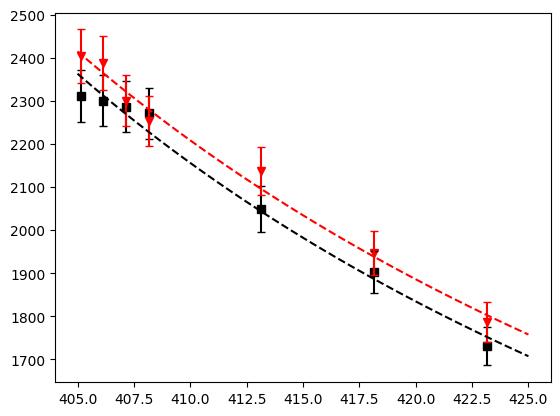

In [120]:
#   Curie-Weiss fit for T>Tc

Tc = 405
index = data.index[data['T'] > Tc][0]
neg_index = - len(data['T']) + index
fit_S, cov_S = curve_fit (cw, data['T'].loc[index:], data['SUBIDA'].loc[index:], sigma = sE_S[index:])
fit_B, cov_B = curve_fit (cw, data['T'].loc[index:], data['BAJADA'].loc[index:], sigma = sE_B[neg_index:])



ax.plot(data['T'].loc[index:], data['SUBIDA'].loc[index:])
ax.plot(data['T'].loc[index:], data['BAJADA'].loc[index:])
plt.errorbar(x = data['T'].loc[index:], y = data['SUBIDA'].loc[index:], yerr = sE_S[index:], barsabove=True, capsize = 3, fmt = 'ks')
plt.errorbar(x = data['T'].loc[index:], y = data['BAJADA'].loc[index:], yerr = sE_B[neg_index:], barsabove=True, capsize = 3, fmt = 'rv')

x_fit = np.linspace (Tc, 425, 100)

y_fit_S = cw (x_fit, fit_S[0], fit_S[1])
y_fit_B = cw (x_fit, fit_B[0], fit_B[1])


plt.plot(x_fit, y_fit_S, 'k--')
plt.plot(x_fit, y_fit_B, 'r--')

print('C_subida = ', fit_S[0], '$\pm$', np.sqrt(cov_S[0][0]))
print('C_bajada = ', fit_B[0], '$\pm$', np.sqrt(cov_B[0][0]))
print('Tc_subida = ', fit_S[1], '$\pm$', np.sqrt(cov_S[1][1]))
print('Tc_bajada = ', fit_B[1], '$\pm$', np.sqrt(cov_B[1][1]))

ax.set_xlabel('T / K')
ax.set_ylabel('$\epsilon$')
ax.grid(linestyle = '--', color = '#aaaaaa')
plt.savefig('TiBa_para.pdf')

In [121]:
data = pd.read_csv('FES_Curie.csv')


data['T'] = data['T'].astype(float) + 273.15
data['SUBIDA'] = data['SUBIDA'].astype(float) / C0
data['BAJADA'] = data['BAJADA'].astype(float) / C0

C_subida =  120060.85068959523 $\pm$ 5279.24616407888
C_bajada =  126884.07942564509 $\pm$ 5422.31992626946
Tc_subida =  354.3255970961984 $\pm$ 23.9299826821316
Tc_bajada =  352.5592494302858 $\pm$ 23.2077241535331


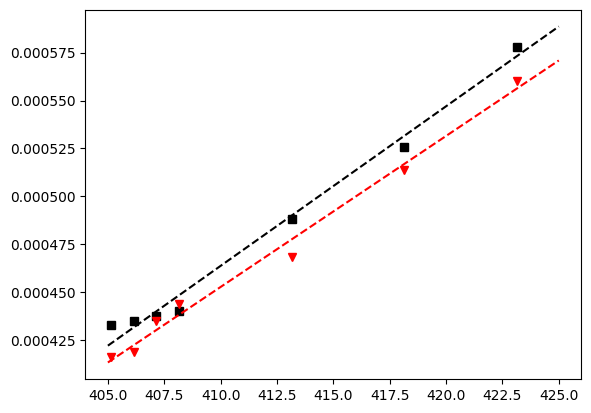

In [122]:
#   Representación 1/\chi

ax1 = plt.gca()

data['SUBIDA'] = 1. / (data['SUBIDA']-1)
data['BAJADA'].loc[start:] = 1. / (data['BAJADA']-1)


sX_S = []
sX_B = []

for i in range(len(data['SUBIDA'])):
    sX_S.append(inc.incerts (1./(x-1), [x], [data['SUBIDA'].loc[i]], [sE_S[i]]))
for i in range(len(data['BAJADA'].loc[start:])):
    sX_B.append(inc.incerts (1./(x-1), [x], [data['BAJADA'].loc[i + start]], [sE_S[i + start]]))



#plt.errorbar(x = data['T'].loc[index:], y = data['SUBIDA'].loc[index:], yerr = sX_S[index:], barsabove=True, capsize = 3, fmt = 'ks')
#plt.errorbar(x = data['T'].loc[index:], y = data['BAJADA'].loc[index:], yerr = sX_B[neg_index:], barsabove=True, capsize = 3, fmt = 'rv')

ax1.plot(data['T'].loc[index:], data['SUBIDA'].loc[index:], 'ks')
ax1.plot(data['T'].loc[index:], data['BAJADA'].loc[index:], 'rv')

fit_chi_S, cov_chi_S = curve_fit (rect, data['T'].loc[index:], data['SUBIDA'].loc[index:], sigma = sX_S[index:])
fit_chi_B, cov_chi_B = curve_fit (rect, data['T'].loc[index:], data['BAJADA'].loc[index:], sigma = sX_B[neg_index:])


x_fit = np.linspace (Tc, 425, 100)

y_fit_S = rect (x_fit, fit_chi_S[0], fit_chi_S[1])
y_fit_B = rect (x_fit, fit_chi_B[0], fit_chi_B[1])


plt.plot(x_fit, y_fit_S, 'k--')
plt.plot(x_fit, y_fit_B, 'r--')

ax.set_xlabel('T / K')
ax.set_ylabel('$\epsilon$')
ax.grid(linestyle = '--', color = '#aaaaaa')
plt.savefig('TiBa_rect.pdf')

print('C_subida = ', 1. / fit_chi_S[0], '$\pm$', inc.incerts (1. / x, [x], [fit_chi_S[0]], [np.sqrt(cov_chi_S[0][0])]))
print('C_bajada = ', 1. / fit_chi_B[0], '$\pm$', inc.incerts (1. / x, [x], [fit_chi_B[0]], [np.sqrt(cov_chi_B[0][0])]))
print('Tc_subida = ', -1. / fit_chi_S[0] * fit_chi_S[1], '$\pm$', inc.incerts(-x / y, [x, y], [fit_chi_S[1], fit_chi_S[0]], [np.sqrt(cov_chi_S[1][1]), np.sqrt(cov_chi_S[0][0])]))
print('Tc_bajada = ', -1. / fit_chi_B[0] * fit_chi_B[1], '$\pm$', inc.incerts(-x / y, [x, y], [fit_chi_B[1], fit_chi_B[0]], [np.sqrt(cov_chi_B[1][1]), np.sqrt(cov_chi_B[0][0])]))

$\Huge{Sulfato\ de\ Triglicina}$

In [127]:
#   Redefine global constants
l = 10e-3
sl = 0.5e-3
a = 6e-3
sa = 0.5e-3
d = 2e-3
sd = 0.5e-3
ATGS = l * a
sATGS = inc.incerts(x * y, [x, y], [l, a], [sl, sa])

C0 = E * A / d
sC0TGS =  E * inc.incerts(x / y, [x, y], [ATGS, d], [sATGS, sd])

In [128]:
df = pd.read_csv('TGS.csv')

df['T'] = df['T'].astype(float) + 273.15
df['C'] = df['C']. astype(float)
sC = errorC * df['C']
sE = []
for i in range (len(df['C'])):
    sE.append(inc.incerts (x / y, [x, y], [df['C'].loc[i], C0], [sC.loc[i], sC0TGS]))


df['C'] = df['C']. astype(float) / C0

[126.288092221697, 126.288092221697, 126.288092221697, 126.288092221697, 127.386249545364, 127.386249545364, 127.386249545364, 127.386249545364, 131.778878840031, 131.778878840031, 131.778878840031, 131.998510304765, 132.986851896065, 132.986851896065, 133.975193487365, 133.975193487365, 135.073350811032, 136.171508134699, 137.269665458366, 138.367822782033, 139.465980105700, 140.564137429367, 141.662294753034, 141.662294753034, 143.858609400368, 144.956766724035, 146.054924047701, 148.251238695035, 148.251238695035, 150.447553342369, 151.545710666036, 152.643867989703, 154.840182637037, 154.840182637037, 157.036497284371, 159.232811931705, 161.429126579038, 162.527283902705, 163.625441226372, 164.723598550039, 166.919913197373, 169.116227844707, 172.410699815708, 173.508857139375, 175.705171786708, 177.901486434042, 180.097801081376, 182.294115728710, 184.490430376044, 186.686745023378, 189.981216994379, 192.177531641712, 194.373846289046, 197.668318260047, 199.864632907381, 203.15910

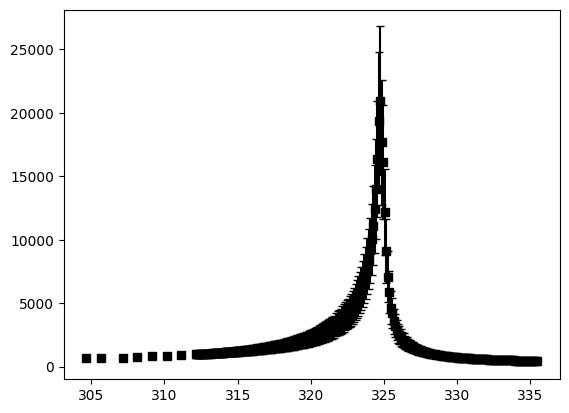

In [129]:
#df.plot(x = 'T', y = 'C', style = 'ks')
plt.errorbar (df['T'], df['C'], yerr = sE, fmt = 'ks', capsize = 3)
Tc_TGS_index = np.argmax(df['C'])
print(sE)
print(df['T'].loc[Tc_TGS_index])
Tc_TGS = df['T'].loc[Tc_TGS_index]

[3959.65220602  324.62365104]


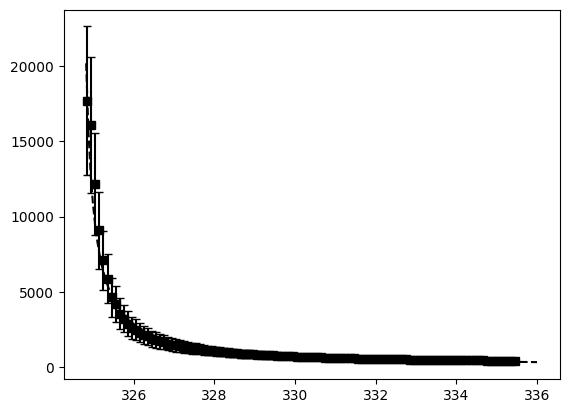

In [134]:
#   Fit c-w

ax2 = plt.gca()

plt.errorbar(df['T'].loc[:Tc_TGS_index-1], df['C'].loc[:Tc_TGS_index-1], yerr = sE[:Tc_TGS_index], fmt = 'ks', capsize = 3)

fit_TGS, cov_TGS = curve_fit (cw, df['T'].loc[:Tc_TGS_index-1], df['C'].loc[:Tc_TGS_index-1], p0 = [1e3, 324.5], sigma = sE[:Tc_TGS_index])

print(fit_TGS)
x_fit = np.linspace(Tc_TGS + 0.07, 336, 200)

y_fit = cw(x_fit, fit_TGS[0], fit_TGS[1])

ax2.plot(x_fit, y_fit, 'k--')